In [63]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
import pyrootutils

base_path = pyrootutils.setup_root(
    search_from=".",
    indicator=[".gitignore"],
    project_root_env_var=True,  # set the PROJECT_ROOT environment variable to root directory
    dotenv=True,  # load environment variables from .env if exists in root directory
    pythonpath=True,  # add root directory to the PYTHONPATH (helps with imports)
    cwd=True,  # change current working directory to the root directory (helps with filepaths)
)
import sys
import pandas as pd
import scanpy as sc
import squidpy as sq
import matplotlib.pyplot as plt
import seaborn as sns
import json
import wandb
import matplotlib
import matplotlib as mpl
from itertools import combinations
import os
import shutil

from src.utils.metrics import *
from src.data.utils import *
from src.utils.eval import *

In [65]:
# experiment_name = "experiment_mouse_st"
# sc_path = "../data/single-cell/Allenbrain_forSimulation_uniquect.h5ad"
# st_path = "../data/spatial/V1_Mouse_Brain_Sagittal_Anterior.h5ad"

experiment_name = "experiment_kidney_slideSeq_v2_105"
# sc_path = "../data/single-cell/kidney_slideSeq_v2_105.h5ad"
st_path = (
    "./data/spatial/simulations_kidney_slideSeq_v2/UMOD-KI.KI-4b_resolution105.h5ad"
)

experiment_name = "experiment_kidney_slideSeq_v2_UMOD-WT.WT-2a_resolution75"
# sc_path = "../data/single-cell/kidney_slideSeq_v2_105.h5ad"
st_path = (
    "./data/spatial/simulations_kidney_slideSeq_v2/UMOD-WT.WT-2a_resolution75.h5ad"
)

experiment_name = "experiment_heart_seqFISH_embryo1_resolution0.11"
experiment_name = "experiment_heart_seqFISH_embryo1_resolution0.11-new"
# experiment_name = "experiment_heart_seqFISH_embryo1_resolution0.11-ica"
st_path = "./data/spatial/simulations_heart_seqFISH/embryo1_resolution0.11.h5ad"
sc_path = "./data/spatial/heart_seqFISH/embryo1.h5ad"

In [66]:
experiment_dir = f"{base_path}/experiments"
experiment_path = f"{experiment_dir}/{experiment_name}"

In [67]:
# load sample names and celltype names
celltypes = load_celltypes(f"{experiment_path}/datasets/celltypes.txt")
sample_names = load_sample_names(f"{experiment_path}/datasets/sample_names.txt")

In [68]:
# sc_data = sc.read_h5ad(sc_path)

st_data = sc.read_h5ad(st_path)
y_real = st_data.obs[st_data.obs.columns[2::]].to_numpy()
y_real = st_data.obs[st_data.obs.columns[2::]]

if "Forebrain/Midbrain/Hindbrain" in y_real.columns:
    y_real = y_real.rename(
        {"Forebrain/Midbrain/Hindbrain": "Forebrain_Midbrain_Hindbrain"}, axis=1
    )

## Load original DISSECT results

In [69]:
# load celltype abundance data
dissect_results = []
for i in range(5):
    df = pd.read_csv(
        f"{experiment_path}/dissect_fractions_{i}.txt", index_col=0, delimiter="\t"
    )
    dissect_results.append(df)
ensemble_result = pd.read_csv(
    f"{experiment_path}/dissect_fractions_ens.txt", index_col=0, delimiter="\t"
)
dissect_results.append(ensemble_result)

gnn_results = None

## Load new results

In [ ]:
# new_result = pd.read_csv(f"{experiment_path}/new_predictions.csv", index_col=0)
new_results = pd.read_csv(f"{experiment_path}/gnn_predictions.csv", index_col=0)
# donwload results from wandb

In [15]:
def get_result_for_run_name(run_name):
    api = wandb.Api()
    entity, project = "dschaub", "dissect-spatial"  # set to your entity and project
    runs = api.runs(entity + "/" + project)
    run = [run for run in runs if run.name == run_name][0]
    # filter file
    result_file = [
        file
        for file in run.files()
        if "table" in file.name and "step-5000" in file.name
    ][0]
    # load file in memory and convert to df
    path = result_file.download(replace=False, exist_ok=True).name
    with open(path, "r") as f:
        result = json.load(f)
    result_df = pd.DataFrame(result["data"], columns=result["columns"]).set_index(
        "sample_names"
    )
    # delete file
    return result_df

In [ ]:
# run_names = [
#     "Dissect reimplement no pos",
#     "Dissect reimplement with pos",
#     "GNN with self-loops only",
#     "GNN radius 0.05",
#     "GNN radius 0.035",
#     "GNN radius 0.02",
#     "GNN radius 0.035 alpha 0.0-0.1",
#     "Lin layer alpha 0.0-0.1",
#     "self-loops + lin layer, concat simple",
#     "Transformer with pos, with id",
# ]
run_names = [
    "UMOD-WT.WT-2a self-loops",
]
gnn_results = [get_result_for_run_name(run_name) for run_name in run_names]
if len(gnn_results) == 0:
    gnn_results = []

## Evaluate results

### Compare with ground truth

In [70]:
try:
    run_names[0]
except:
    run_names = []
    gnn_results = []
methods_names = 5 * ["DISSECT"] + ["DISSECT ensemble"] + run_names
print(gnn_results)
results = dissect_results + gnn_results

[]


In [79]:
cellwise_results = compare_methods_new(
    dissect_results, y_real, methods=methods_names, samplewise=False
)
samplewise_results = compare_methods_new(
    dissect_results, y_real, methods=methods_names, samplewise=True
)

In [48]:
cellwise_results

,Correlation,RMSE,Celltype,Method,Fold,Method fold
0,0.386512,0.043710,Allantois,DISSECT,0,DISSECT-0
1,0.350003,0.056667,Anterior somitic tissues,DISSECT,0,DISSECT-0
2,0.198363,0.045365,Blood progenitors,DISSECT,0,DISSECT-0
3,0.957884,0.110938,Cardiomyocytes,DISSECT,0,DISSECT-0
4,0.901739,0.138328,Cranial mesoderm,DISSECT,0,DISSECT-0
...,...,...,...,...,...,...
133,0.937675,0.073789,Presomitic mesoderm,DISSECT ensemble,0,DISSECT ensemble-0
134,0.422208,0.042597,Sclerotome,DISSECT ensemble,0,DISSECT ensemble-0
135,0.864340,0.235785,Spinal cord,DISSECT ensemble,0,DISSECT ensemble-0
136,0.867589,0.143280,Splanchnic mesoderm,DISSECT ensemble,0,DISSECT ensemble-0


In [80]:
cellwise_grouped = cellwise_results.groupby(["Method", "Fold"]).mean(numeric_only=True)
samplewise_grouped = samplewise_results.groupby(["Method", "Fold"]).mean(numeric_only=True)
pd.concat([cellwise_grouped, samplewise_grouped], axis=1)

Correlation      RMSE       CCC  \
Method           Fold                                    
DISSECT          0        0.693014  0.101651  0.483623   
                 1        0.686557  0.104820  0.470297   
                 2        0.687885  0.103306  0.483114   
                 3        0.668245  0.108599  0.437884   
                 4        0.674351  0.106964  0.450776   
DISSECT ensemble 0        0.704658  0.103814  0.472756   

                       Correlation (samplewise)  RMSE (samplewise)  \
Method           Fold                                                
DISSECT          0                     0.817460           0.106948   
                 1                     0.815484           0.110731   
                 2                     0.817253           0.109969   
                 3                     0.781876           0.115474   
                 4                     0.804457           0.114901   
DISSECT ensemble 0                     0.834465           0.110715   

                       CCC (samplewise)  
Method           Fold                    
DISSECT          0             0.598089  
                 1             0.583174  
                 2             0.586580  
                 3             0.541633  
                 4             0.548089  
DISSECT ensemble 0             0.581035

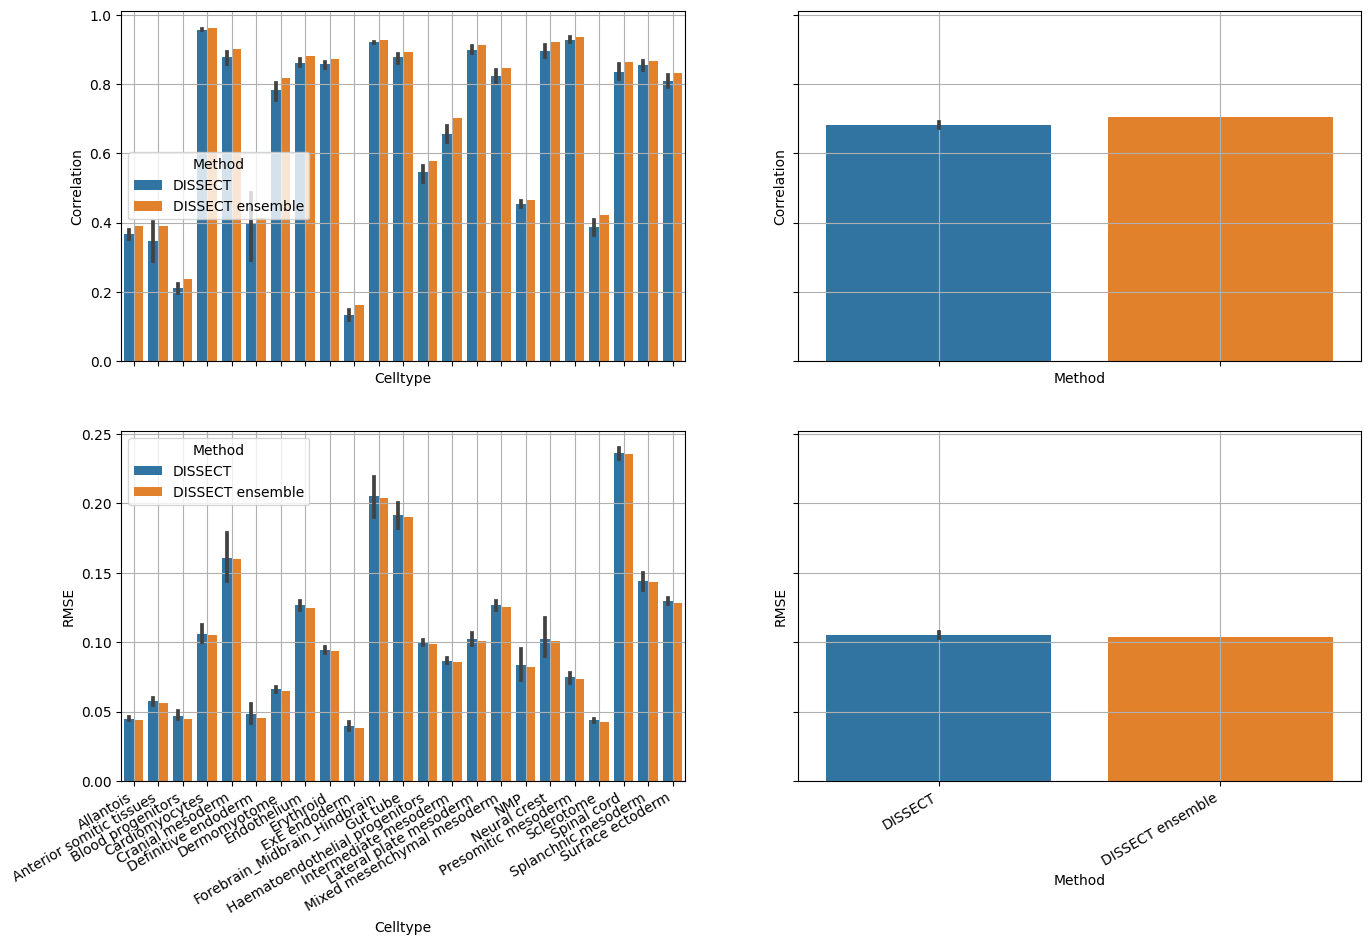

In [60]:
# plot performance per celltype
fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharey="row", sharex="col")
axs = np.ravel(axs)
sns.barplot(cellwise_results, x="Celltype", y="Correlation", hue="Method", ax=axs[0])
mean_cellwise_results = cellwise_results.groupby(
    ["Method", "Fold"], as_index=False
).mean(numeric_only=True)
sns.barplot(mean_cellwise_results, x="Method", y="Correlation", ax=axs[1])

sns.barplot(cellwise_results, x="Celltype", y="RMSE", hue="Method", ax=axs[2])
mean_cellwise_results = cellwise_results.groupby(
    ["Method", "Fold"], as_index=False
).mean(numeric_only=True)
sns.barplot(mean_cellwise_results, x="Method", y="RMSE", ax=axs[3])
# rotate xticks
for ax in axs[-2:]:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")
for ax in axs:
    ax.grid(True)

plt.savefig(
    f"./figures/evaluation_{experiment_name}_cellwise.png", dpi=200, bbox_inches="tight"
)
plt.show()

/tmp/ipykernel_21637/544723042.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_samplewise_results = samplewise_results.groupby(["Method", "Fold"], as_index=False).mean()


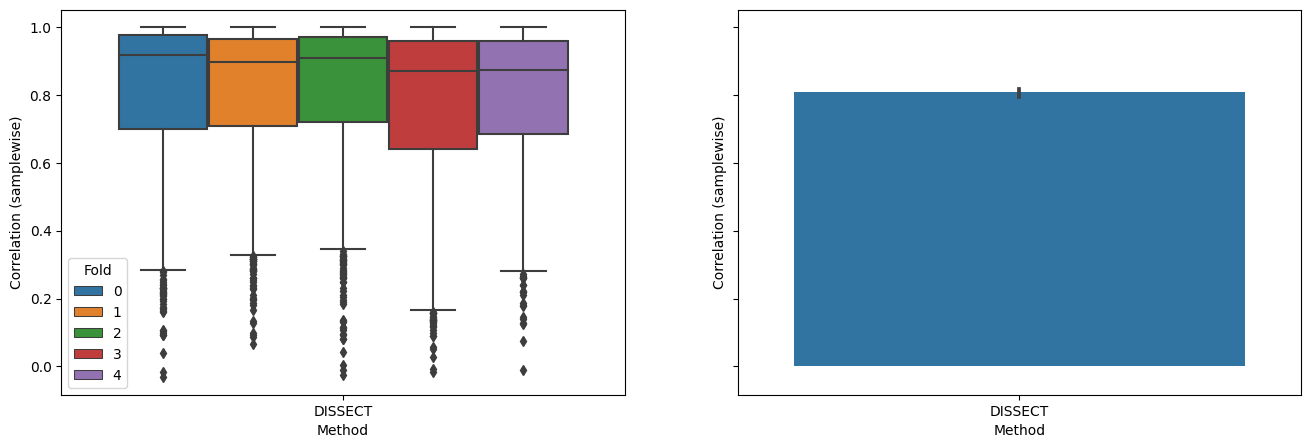

/tmp/ipykernel_21637/544723042.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_samplewise_results = samplewise_results.groupby(["Method", "Fold"], as_index=False).mean()


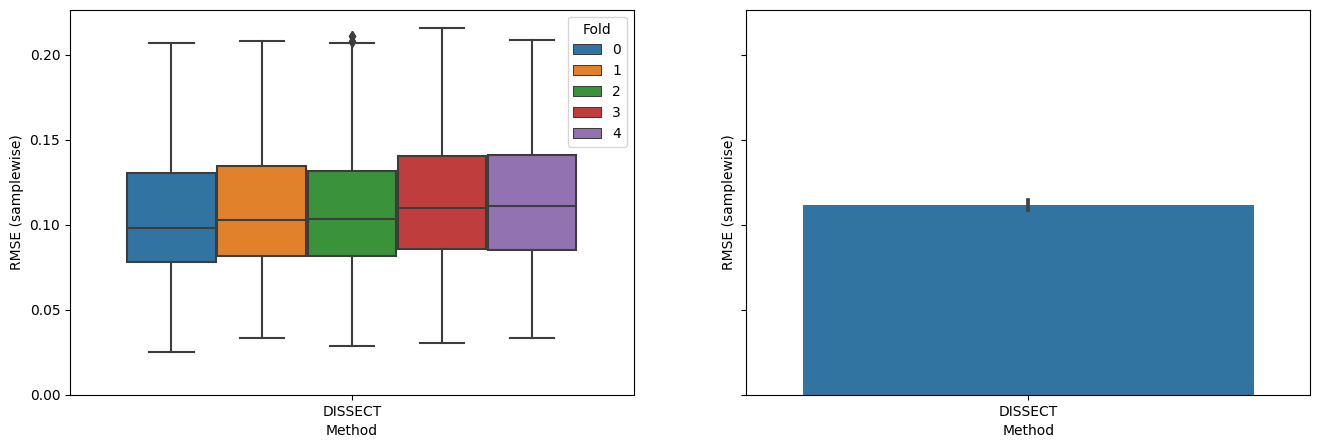

In [79]:
# samplewise results
# plot performance per celltype
metrics = ["Correlation", "RMSE"]
for metric in metrics:
    fig, axs = plt.subplots(1, 2, figsize=(16, 5), sharey="row", sharex="col")
    sns.boxplot(
        samplewise_results,
        x="Method",
        y=metric + " (samplewise)",
        hue="Fold",
        ax=axs[0],
    )
    mean_samplewise_results = samplewise_results.groupby(
        ["Method", "Fold"], as_index=False
    ).mean()
    sns.barplot(
        mean_samplewise_results, x="Method", y=metric + " (samplewise)", ax=axs[1]
    )
    # plt.savefig(
    #     f"./figures/evaluation_{experiment_name}_cellwise.png", dpi=200, bbox_inches="tight"
    # )
    plt.show()

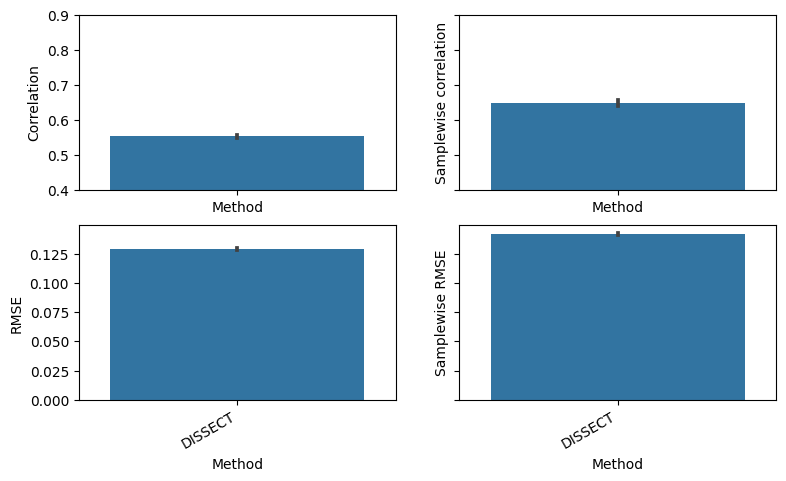

In [41]:
# compare gnn with dissect
# make barplot comparing mean correaltion and rmse for both methods
fig, ax = plt.subplots(2, 2, figsize=(9, 5), sharey="row", sharex=True)
ax = np.ravel(ax)
for k, col in enumerate(comparison_df.columns):
    if col == "Method":
        continue
    sns.barplot(x="Method", y=col, data=comparison_df, ax=ax[k])
    # rotate xticks
    ax[k].set_xticklabels(ax[k].get_xticklabels(), rotation=30, ha="right")
    # set ax limits
    if "lation" in col:
        ax[k].set_ylim([0.4, 0.9])
    else:
        # ax[k].set_ylim([0.05, 0.11])
        pass
plt.savefig(
    f"./figures/gnn_vs_dissect_{experiment_name}.png", dpi=200, bbox_inches="tight"
)
plt.show()

### Predicted max celltype per spot

In [ ]:
for k, df in enumerate(results_per_seed):
    max_celltypes = df.idxmax(axis=1)
    st_data.obs[f"celltype-{k}"] = max_celltypes
    sq.pl.spatial_scatter(st_data, color=f"celltype-{k}")

### Celltype distribution across tissue

In [ ]:
st_data.obs[celltypes] = new_result[celltypes]
sq.pl.spatial_scatter(st_data, color="L5 IT")
plt.savefig(
    f"{base_path}/figures/single_celltype_{experiment_name}.png",
    dpi=200,
    bbox_inches="tight",
)

In [ ]:
st_data.obs[celltypes] = ensemble_result[celltypes]
sq.pl.spatial_scatter(st_data, color=celltypes)

### Comparison between dissect runs for different seeds

In [ ]:
all_corrs = []
for df_1 in results_per_seed:
    for df_2 in results_per_seed:
        all_corrs.append(calc_mean_corr_df(df_1, df_2, verbose=1)[0])
    # calc correlation
all_corrs = np.reshape(all_corrs, (5, 5))

In [ ]:
labels = [f"Seed {i}" for i in range(5)]

In [ ]:
def heatmap(
    data, row_labels, col_labels, ax=None, cbar_kw=None, cbarlabel="", **kwargs
):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right", rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1] + 1) - 0.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0] + 1) - 0.5, minor=True)
    ax.grid(which="minor", color="w", linestyle="-", linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(
    im,
    data=None,
    valfmt="{x:.2f}",
    textcolors=("black", "white"),
    threshold=None,
    **textkw
):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max()) / 2.0

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center", verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [ ]:
fig, ax = plt.subplots()

im, cbar = heatmap(
    all_corrs, labels, labels, ax=ax, cmap="Blues", cbarlabel="Pearson correlation"
)
texts = annotate_heatmap(im, valfmt="{x:.2f}")
ax.set_title("Correlation between seeded runs in original DISSECT")

fig.tight_layout()
plt.savefig(
    "../figures/corr_heatmap_dissect_original.png", dpi=200, bbox_inches="tight"
)
plt.show()

### Comparison with new implementation

In [ ]:
new_corrs = []
for df in results_per_seed:
    new_corrs.append(calc_mean_corr_df(df, new_result)[0])
new_corrs = np.reshape(new_corrs, (5, 1))

In [ ]:
fig, ax = plt.subplots()
ax.boxplot(new_corrs)
ax.set_xticklabels(" ")
ax.set_title("Mean correlation between seeded runs and new DISSECT")
fig.tight_layout()
plt.savefig("../figures/corr_dissect_new_vs_old.png", dpi=200, bbox_inches="tight")
plt.show()

In [ ]:
print(np.mean(new_corrs))
print(np.std(new_corrs))
print(np.max(new_corrs))
print(np.min(new_corrs))

## Compare per cell type

In [17]:
(
    mean_corr,
    corrs,
    mean_corr_sample,
    corrs_sample,
    mean_rmse,
    rmses,
    mean_rmse_sample,
    rmses_sample,
) = calc_metrics_df(ensemble_result, y_real, verbose=1, exclude_cols=None)

Mean Correlation: 0.6665105134941514
Mean Correlation (samplewise): 0.8199102536595623
Mean RMSE: 0.08039174338627984
Mean RMSE (samplewise): 0.08848945796303827


<BarContainer object of 13 artists>

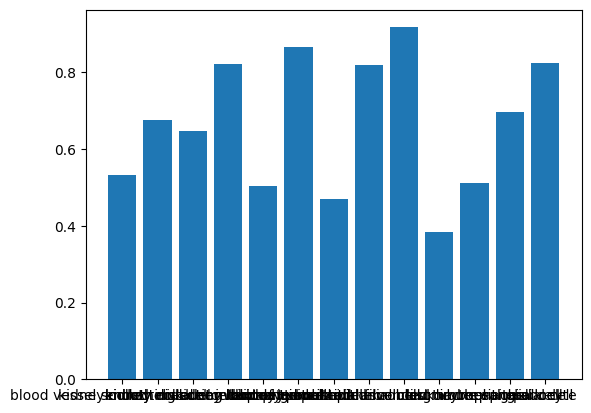

In [13]:
# plot corrs per cell type
fig, ax = plt.subplots()
cell_types = y_real.columns
ax.bar(cell_types, corrs)

In [14]:
for col in ensemble_result.columns:
    st_data.obs[f"{col} pred"] = ensemble_result[col]

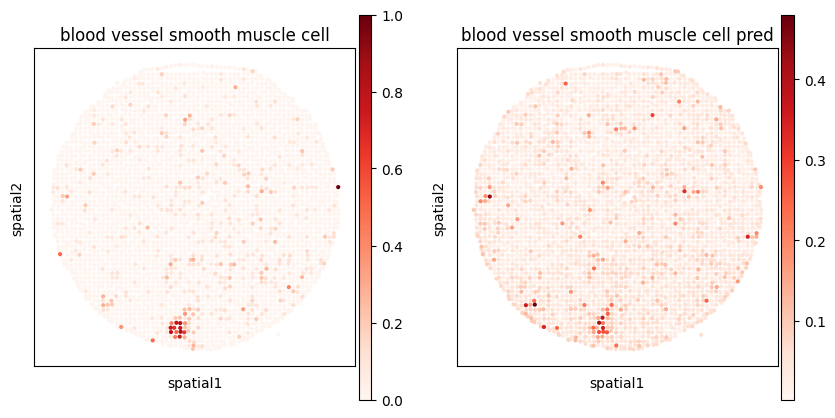

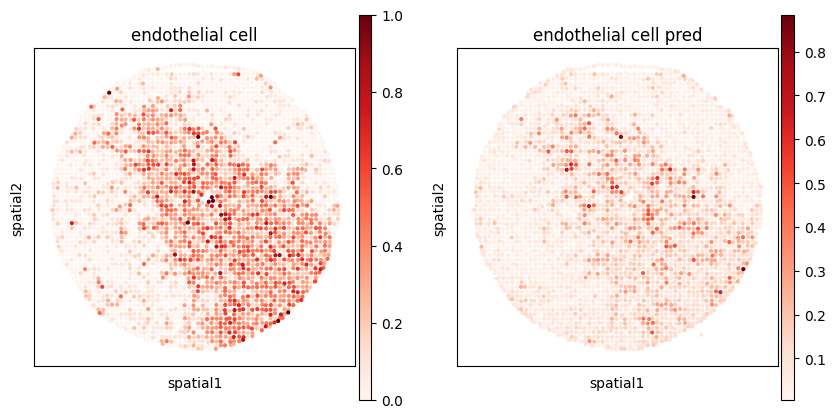

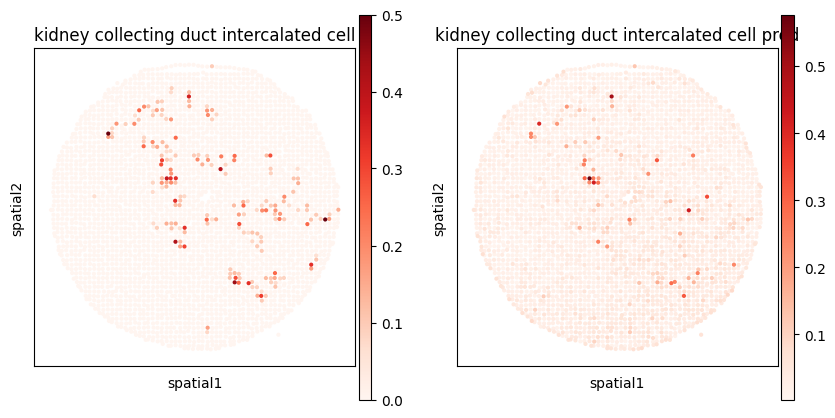

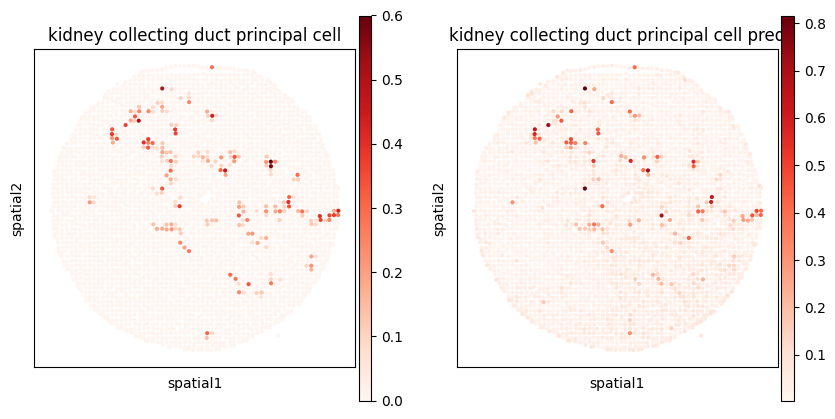

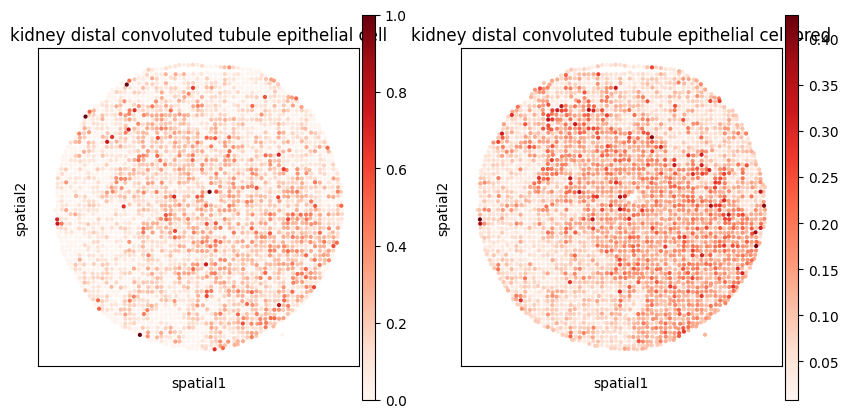

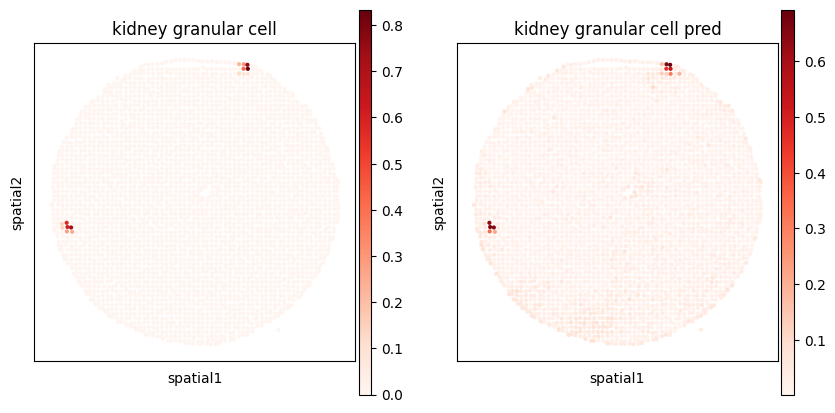

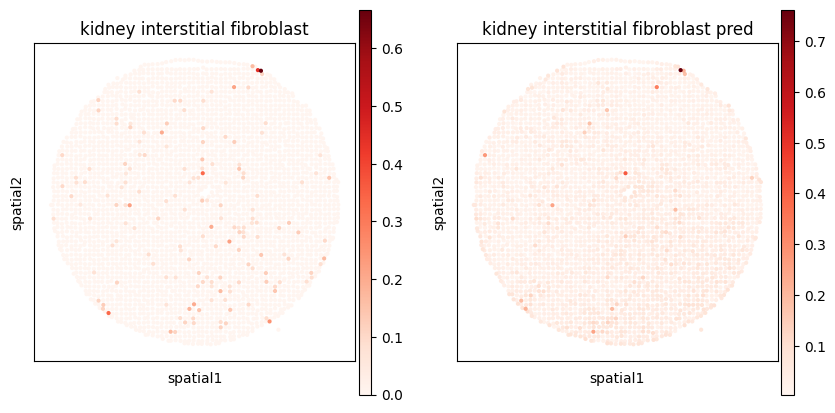

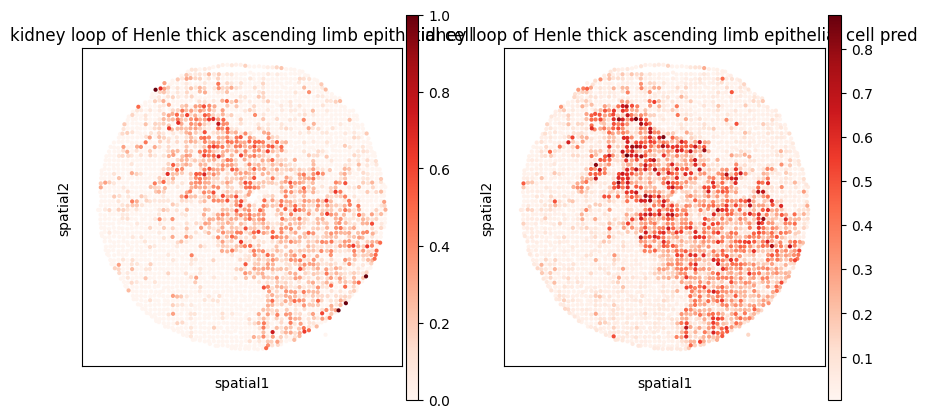

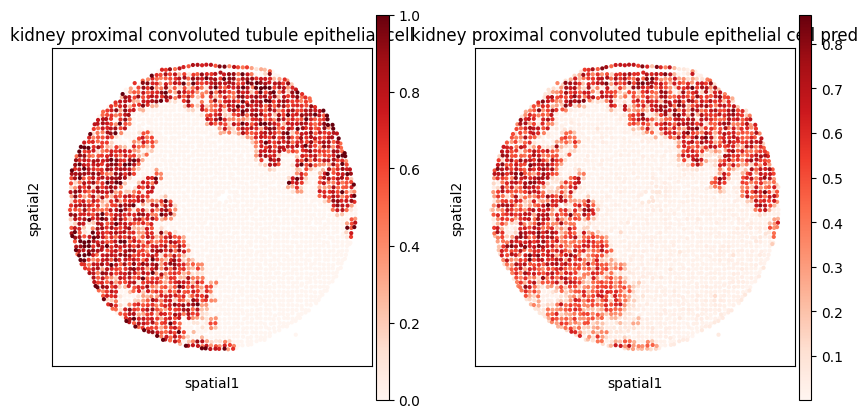

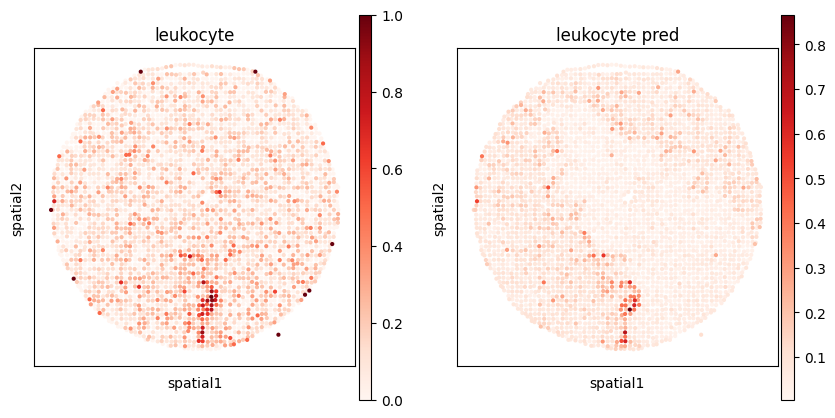

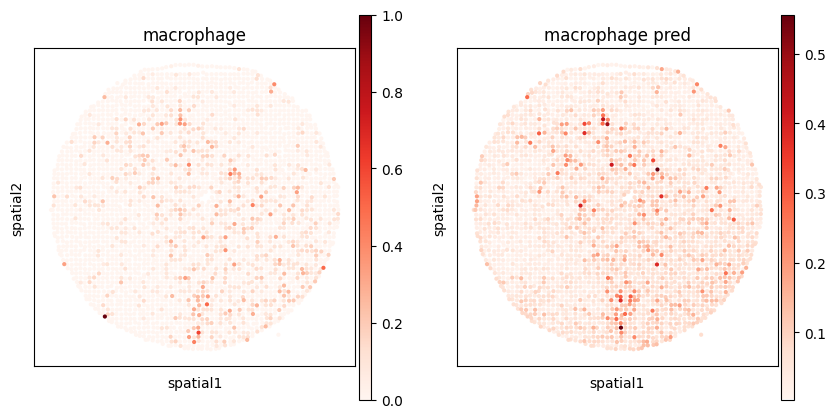

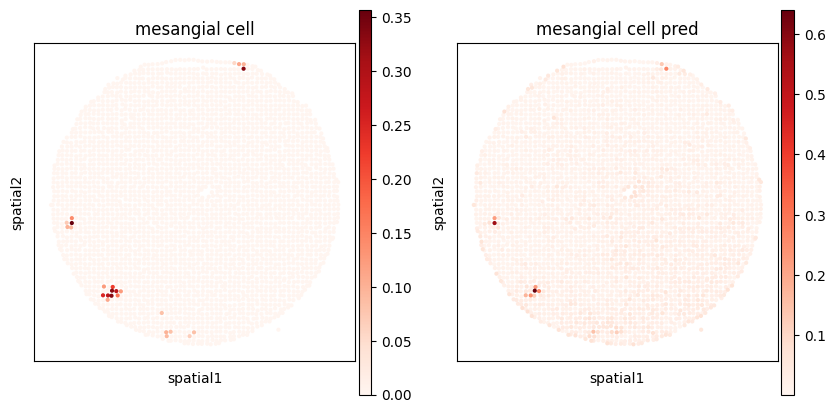

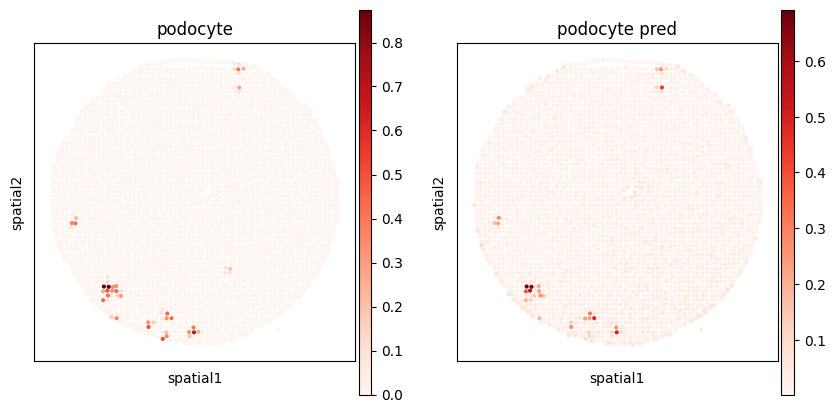

In [15]:
for col in ensemble_result.columns:
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    sc.pl.spatial(st_data, color=col, ax=axs[0], show=False, cmap="Reds")
    sc.pl.spatial(st_data, color=f"{col} pred", ax=axs[1], cmap="Reds")

In [24]:
for col in ensemble_result.columns:
    st_data.obs[f"{col} pred"] = ensemble_result[col]